In [1219]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import math
from os import listdir
import data_visualization as dv
import pickle
import scipy 
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm 
import random
import numba as nb
from numba import njit
from operator import itemgetter
import matplotlib as mpl
'''
v2 Now uses the probability that the agent has gone and hasn't gone to determine if 
someone is actually going to select the action of react or gamble... This has reduced down indecisions from the previous iteration.
So I'm thinking of adding in timing variability now

This now includes coincidence timing sd, and it fits the 1000,50 perfectly, then predicts that humans make too many indecisions for all other conditions

'''

"\nv2 Now uses the probability that the agent has gone and hasn't gone to determine if \nsomeone is actually going to select the action of react or gamble... This has reduced down indecisions from the previous iteration.\nSo I'm thinking of adding in timing variability now\n\nThis now includes coincidence timing sd, and it fits the 1000,50 perfectly, then predicts that humans make too many indecisions for all other conditions\n\n"

## Initial Thangs

In [1220]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()

In [1221]:
os.chdir('D:\\Subject_Data\\Seth_MatchPennies_Agent_Exp1\\')
PATH = os.getcwd()
SAVE_PATH = 'C:\\Users\\Seth Sullivan\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\Modeling Figures\\Optimal Stopping Expected Reward Figures Group\\'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
os.chdir('D:\Subject_Data\Seth_MatchPennies_Agent_Exp1')
PATH = os.getcwd()
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH+"\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Figures_Pull_List_Control.txt", "r") as pull_file:
    analysis_pull_list_control = pull_file.read().splitlines()
with open(PATH+"\\Figures_Pull_List_Task.txt", "r") as pull_file:
    analysis_pull_list_task = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
NUM_SUBJECTS = len(figures_pull_list)
task_name = 'Seth_MatchPennies_Agent_Exp1'

In [1222]:
#%% Plot properties
box_lw = 2.5 #box linewidth
boxwidth = .07 #box width
whisker_lw = 2.0 #whisker linewidth
circle_size = 8 

tp3_title = "1000 \n(50)"
tp4_title = "1000 \n(150)"
tp5_title = '1100 \n(50)'
tp6_title = "1100 \n(150)"
tp7_title = "1200 \n(50)"
tp8_title = '1200 \n(150)'
tp9_title = '1300 \n(10)0'
tp10_title ='1300 \n(20)0'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]

box_color1 = wheel.seth_red
box_color2 = wheel.seth_blue
box_color3 = '0.4'
#boxprops
two_props = {"facecolor": "none", "edgecolor" : box_color1, "linewidth": box_lw, "alpha": 1}
three_props = {"facecolor": "none", "edgecolor" : box_color2, "linewidth": box_lw, "alpha": 1}
four_props = {"facecolor": "none", "edgecolor" : box_color3, "linewidth": box_lw, "alpha": 1}
#whiskerprops
two_whisk = {"linewidth" : whisker_lw, "color": box_color1}
three_whisk = {"linewidth" : whisker_lw, "color": box_color2}
four_whisk = {"linewidth" : whisker_lw, "color": box_color3}
#capprops
two_cap = {"linewidth" : whisker_lw, "color": box_color1}
three_cap = {"linewidth" : whisker_lw, "color": box_color2}
four_cap = {"linewidth" : whisker_lw, "color": box_color3}
#medianprops
two_median = {"linewidth" : whisker_lw, "color": box_color1}     
three_median = {"linewidth" : whisker_lw, "color": box_color2}   
four_median = {"linewidth" : whisker_lw, "color": box_color3}        
    
#total_indecisions = np.concatenate((perc_player_indecisions,perc_indecisions_R))
props = [{}, {}, {}, {}, {}, {}]
props_dict = {}
box_color = 'grey'
dot_color = 'black'   

## Functions

### Boxplot Function

In [1223]:
#%% Box plot with option to make double boxplot
def boxplot(data, xlocs, ylocs, box_widths = 0.15, shift_box = False, shift_direction = 1, 
            legend_labels = None, xlab = None, ylab=None, title=None):
    og_xlocs = xlocs
    box_xlocs = xlocs
    props = [two_props,two_whisk,two_cap,two_median]
    if shift_box:
        box_xlocs = box_xlocs + shift_direction*box_widths*4
        xlocs = xlocs + shift_direction*box_widths*4
        if shift_direction == 1:
            props = [three_props,three_whisk,three_cap,three_median]
        else:
            props = [two_props,two_whisk,two_cap,two_median]

    filtered_data = data
    if np.isnan(data).any():
        mask = ~np.isnan(data)
        filtered_data = [d[m] for d,m in zip(data.T, mask.T)]
    else:
        filtered_data = data
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    ax.boxplot(filtered_data, positions=box_xlocs, patch_artist=True, boxprops = props[0], whiskerprops = props[1], 
                capprops = props[2], medianprops = props[3], showfliers=False, widths = (box_widths)*len(xlocs))
    ax.set_xticks(og_xlocs) 
    #ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    if shift_box:
        colors = [wheel.seth_red, wheel.seth_blue]
        dv.Custom_Legend(ax, legend_labels, colors, fontsize = 12)

### Jitter

In [1224]:
def jitter(xlocs, data):
    if data.ndim >1:
        xlocs = np.tile(xlocs,(np.shape(data)[0],1))
        xlocs = xlocs + np.random.normal(0,0.05, np.shape(data))
    else:
        xlocs = xlocs + np.random.normal(0,0.05, np.shape(data))
    return xlocs

### Optimal Expected Reward Function

In [1225]:
def find_optimal_decision_time(agent_mean, agent_std, reaction_time,movement_time, reaction_uncertainty, movement_uncertainty,timing_uncertainty,plot=False):
    timesteps = np.arange(0,2000,1)
    prob_agent_go = np.zeros(len(timesteps))
    prob_agent_no_go = np.zeros(len(timesteps))
    prob_making_react = np.zeros(len(timesteps))
    prob_making_gamble = np.zeros(len(timesteps))
    prob_agent_making = np.zeros(len(timesteps))

    expected_reward = np.zeros(len(timesteps))
    expected_reward_gamble = np.zeros(len(timesteps))
    expected_reward_react = np.zeros(len(timesteps))
    prob_reward_gamble = np.zeros(len(timesteps))
    prob_reward_react = np.zeros(len(timesteps))
    prob_reward = np.zeros(len(timesteps))
    reaction_movement_time = reaction_time + movement_time

    

    prob_success_gamble = 0.5 # IT'S NOT ABOUT THE PROBABILITY THAT I WILL SUCCEED WITH EACH ACTION... IT'S ABOUT THE PROBABILITY THAT I WILL BE ABLE TO SELECT THE OPTIMAL ACTION
    prob_success_react = 1.0
    win_reward = 1.0
    loss_cost = 0
    indecision_cost = 0
    
    prob_agent_go = stats.norm.cdf(timesteps,agent_mean,agent_std)
    prob_agent_no_go = 1 - prob_agent_go
    prob_agent_making = stats.norm.cdf(1500-timesteps,agent_mean,agent_std)
    
    # Calculate reaction movement uncertainty basedon prob_agent_go
    reaction_movement_uncertainty = np.sqrt((movement_uncertainty)**2 + prob_agent_go*(reaction_uncertainty)**2) # We have some uncertainty about making it  
    total_uncertainty_reaction = np.sqrt(reaction_movement_uncertainty**2 + timing_uncertainty**2)
    total_uncertainty_gamble = np.sqrt(movement_uncertainty**2 + timing_uncertainty**2)  
    
    prob_making_react = stats.norm.cdf(1500-timesteps,reaction_movement_time,total_uncertainty_reaction)
    prob_making_gamble = stats.norm.cdf(1500-timesteps,movement_time,total_uncertainty_gamble)

    # THESE AREN'T Multiplied by Agent Probability     
    prob_reward_gamble = (prob_success_gamble)*prob_making_gamble 
    prob_cost_gamble = (1-prob_success_gamble)*prob_making_gamble # Probability of receiving the Cost for being incorrect
    
    prob_reward_react = (prob_success_react)*prob_making_react 
    prob_cost_react = ((1-prob_success_react))*prob_making_react # Probability of receiving the Cost for being incorrect
    
    prob_indecision_gamble = (1 - prob_making_gamble)
    prob_indecision_react = (1 - prob_making_react)    
    
    # Don't need AND subtraction because the prob_agent_go and prob_agent_no_go takes care of it
    # These are multiplied by agent probability, because that's the probability that I SELECT GAMBLE and SELECT REACTION
    prob_reward = prob_reward_gamble*prob_agent_no_go + prob_reward_react*prob_agent_go #- (prob_reward_gamble*prob_reward_react) # NEED TO SUBTRACT THE AND PROBABILITY?... this makes sense... If I go at that time, I at least have 0.5 PLUS the probability that the agent has gone will boost it up
    prob_cost = prob_cost_gamble*prob_agent_no_go + prob_cost_react*prob_agent_go # - (prob_cost_react*prob_cost_gamble)
    prob_indecision = prob_indecision_gamble*prob_agent_no_go + prob_indecision_react*prob_agent_go #- (prob_indecision_gamble*prob_indecision_react) # Probability of indecision depends on if someone gambles
    
    #prob_indecision = prob_indecision_gamble*(1-B) + prob_indecision_react*B - prob_indecision_gamble*(1-B)*B*prob_indecision_react # Probability of indecision depends on if someone gambles 
    
    exp_reward_gamble = prob_reward_gamble*win_reward + prob_cost_gamble*loss_cost + prob_indecision_gamble*indecision_cost
    exp_reward_react = prob_reward_react*win_reward + prob_cost_react*loss_cost + prob_indecision_gamble*indecision_cost
    exp_reward = prob_reward*win_reward + prob_cost*loss_cost + (prob_indecision_gamble)*indecision_cost
    
    if plot:
        fig,ax = plt.subplots(dpi = 125)
        ax.plot(timesteps, prob_reward, label = 'Prob Reward', c = wheel.green, ls = '--')
        ax.plot(timesteps, prob_reward_gamble, label = 'Prob Reward Gamble')
        ax.plot(timesteps, prob_reward_react, label = 'Prob Reward React')
        ax.plot(timesteps,prob_reward_gamble*prob_agent_no_go,label='Gamble Reward*ProbAgentNoGo')
        # ax.plot(timesteps, prob_indecision_gamble)
        ax.set_ylim(-1,1.1)
        ax.set_xlim(0,1500)
        ax.set_xticks(np.arange(0,2000,300))
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Expected Reward')
        ax.legend(fontsize = 8,loc = (0.01,0.1))
        ax.set_title(f'Gain Function for Decision Time')#\n B = {B}')
        plt.show()
        optimal_decision_time  = np.argmax(prob_reward) 
        target_reach_time_on_gambles = optimal_decision_time + movement_time 
        target_reach_time_on_reactions = optimal_decision_time + reaction_movement_time
        print(f'Optimal Decision Time: {optimal_decision_time}') # Remember the task decision time is this 
        print(f'Maximum Expected Reward: {np.max(prob_reward)}')
        print(f'Gamble Target Reach Time: {target_reach_time_on_gambles}')
        print(f'Reaction Target Reach Time: {target_reach_time_on_reactions}')
        
    return np.argmax(prob_reward),np.max(prob_reward)

## Pickle

Pickle Load Control Tasks


In [1226]:
coincidence_trials = 50
reaction_trials = 50
interval_trials = 50
# ---------------Controls-------------------------
player_reaction_decision_array = np.empty((NUM_SUBJECTS, reaction_trials))
agent_reaction_decision_array = np.empty((NUM_SUBJECTS, reaction_trials))
player_reaction_time = np.zeros([NUM_SUBJECTS,reaction_trials])*np.nan 
player_reaction_movement_time = np.zeros([NUM_SUBJECTS,reaction_trials])*np.nan
reaction_trial_start = np.zeros((NUM_SUBJECTS,reaction_trials))*np.nan 
coincidence_trial_start = np.zeros((NUM_SUBJECTS, coincidence_trials))*np.nan
coincidence_reach_time = np.zeros((NUM_SUBJECTS, coincidence_trials))*np.nan
interval_trial_start = np.zeros((NUM_SUBJECTS, interval_trials))*np.nan
interval_reach_time = np.zeros((NUM_SUBJECTS, interval_trials))*np.nan

for i in range(NUM_SUBJECTS):
    subname = figures_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    reaction_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_reaction_trial_start.pkl', 'rb'))
    player_reaction_time[i,:] = pickle.load(open(data_path + f'{subname}_player_reaction_time.pkl', 'rb'))
    player_reaction_movement_time[i,:] = pickle.load(open(data_path + f'{subname}_player_reaction_movement_time.pkl', 'rb'))
    player_reaction_decision_array[i,:] = pickle.load(open(data_path + f'{subname}_player_reaction_decision_array.pkl', 'rb'))
    agent_reaction_decision_array[i,:] = pickle.load(open(data_path + f'{subname}_agent_reaction_decision_time.pkl', 'rb'))
    reaction_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_reaction_trial_start.pkl', 'rb'))
    interval_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_interval_trial_start.pkl', 'rb'))
    interval_reach_time[i,:] = pickle.load(open(data_path + f'{subname}_interval_reach_time.pkl', 'rb'))
    coincidence_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_coincidence_trial_start.pkl', 'rb'))
    coincidence_reach_time[i,:] =  pickle.load(open(data_path + f'{subname}_coincidence_reach_time.pkl', 'rb'))

Pickle Load Task and Washout

In [1227]:
path1 = PATH+'\\'+'Sub1_Task'
task_df = pd.read_csv(path1+f'\\Sub1_TaskTrial_Table.csv')
task_df = task_df.loc[task_df['Condition type']==3] # Only get the task condition 
num_trials = int(task_df.iloc[-1]['Block_Step']) # number of trials in each block
num_blocks = int(task_df.iloc[-1]['Block_Row']/2)
tot_trials = int(num_trials*num_blocks)
trial_time = int(task_df.iloc[0]['Condition time'])
task_df_columns = len(fields_pull)
trial_table = np.empty((NUM_SUBJECTS, tot_trials, 4), int)
#----------------- TASK--------------------------------
player_task_reach_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
player_task_decision_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
player_task_decision_array = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan
player_task_movement_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan
agent_task_reach_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
agent_task_decision_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
agent_task_decision_array = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan

# -------------- Washout-------------------
washout_trials = 25
player_washout_reach_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan 
player_washout_decision_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan 
player_washout_decision_array = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan
player_washout_movement_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan
agent_washout_reach_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan 
agent_washout_decision_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan 
agent_washout_decision_array = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan
agent_washout_movement_time = np.zeros([NUM_SUBJECTS,num_blocks,washout_trials])*np.nan

for i in range(NUM_SUBJECTS):
    subname = figures_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    #task_data[i,:,:,:,:] = pickle.load(open(data_path + f'{subname}_task_data.pkl', 'rb'))
    player_task_decision_time[i,:,:] = pickle.load( open(data_path + f'{subname}_player_task_decision_time.pkl', 'rb'))
    player_task_decision_array[i,:,:] = pickle.load( open(data_path + f'{subname}_player_task_decision_array.pkl', 'rb'))
    player_task_movement_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_task_movement_time.pkl', 'rb'))
    player_task_reach_time[i,:,:] = pickle.load( open(data_path + f'{subname}_player_task_reach_time.pkl', 'rb'))
    agent_task_decision_time[i,:,:] = pickle.load( open(data_path + f'{subname}_agent_task_decision_time.pkl', 'rb'))
    agent_task_decision_array[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_task_decision_array.pkl', 'rb'))
    agent_task_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_task_reach_time.pkl', 'rb'))
    player_washout_decision_time[i,:,:] = pickle.load( open(data_path + f'{subname}_player_washout_decision_time.pkl', 'rb'))
    player_washout_decision_array[i,:,:] = pickle.load( open(data_path + f'{subname}_player_washout_decision_array.pkl', 'rb'))
    player_washout_movement_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_washout_movement_time.pkl', 'rb'))
    player_washout_reach_time[i,:,:] = pickle.load( open(data_path + f'{subname}_player_washout_reach_time.pkl', 'rb'))
    agent_washout_decision_time[i,:,:] = pickle.load( open(data_path + f'{subname}_agent_washout_decision_time.pkl', 'rb'))
    agent_washout_decision_array[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_washout_decision_array.pkl', 'rb'))
    agent_washout_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_washout_reach_time.pkl', 'rb'))

## Calculations

#### Calculations (Control)

Reaction and Reaction Movement Time

In [1228]:
player_reaction_time

array([[570., 417., 289., 319., 315., 346., 333., 315., 356., 457., 243.,
        247., 258., 288., 307., 293., 269., 306., 275., 292., 251., 319.,
        268., 295., 326., 261., 314., 258., 303., 294., 275., 328., 276.,
        286., 264., 249., 270., 271., 257., 277., 239., 312., 261., 255.,
        266., 279., 320., 301., 260., 285.],
       [497., 329., 334., 259., 300., 297., 292., 302., 299., 327., 325.,
        305., 338., 286., 275., 293., 285., 344., 346., 313., 271., 315.,
        318., 298., 283., 300., 330., 299., 349., 314., 338., 337., 335.,
        270., 294., 314., 309., 324., 308., 302., 308., 325., 308., 284.,
        309., 270., 291., 350., 316., 316.],
       [387., 266., 323., 389., 351., 327., 304., 343., 309., 362., 309.,
        343., 272., 263., 292., 323., 264., 328., 313., 338., 378., 346.,
        283., 308., 320., 294., 313., 344., 451., 316., 325., 326., 390.,
        319., 410., 359., 352., 390., 293., 294., 327., 380., 280., 290.,
        352., 282., 37

In [1229]:
#%% Calculate RT means and sds
player_reaction_time = np.where(player_reaction_time<200,np.nan,player_reaction_time) # Anytime someone reacted under 200 ms, replace with nan
reaction_plus_movement_time = player_reaction_time + player_reaction_movement_time
reaction_plus_movement_time_mean = np.nanmean(reaction_plus_movement_time, axis = 1)
reaction_plus_movement_time_sd = np.nanstd(reaction_plus_movement_time,axis=1)
player_reaction_movement_time_mean = np.nanmean(player_reaction_movement_time[:,10:], axis = 1)
player_reaction_movement_time_sd = np.nanstd(player_reaction_movement_time[:,10:], axis = 1)
player_reaction_time_mean = np.nanmean(player_reaction_time[:,10:], axis = 1)
player_reaction_time_median = np.nanmedian(player_reaction_time[:,10:], axis = 1)
player_reaction_time_sd = np.nanstd(player_reaction_time[:,10:], axis = 1)


In [1230]:
player_reaction_time_mean


array([279.95 , 309.875, 330.3  , 339.125, 324.675, 315.05 , 314.875])

In [1231]:
player_reaction_movement_time_mean + player_reaction_time_mean

array([414.575, 424.35 , 454.   , 579.975, 420.725, 436.775, 475.075])

Coincidence Timing

In [1232]:
coincidence_reach_time_mean = np.nanmean(coincidence_reach_time[:,10:], axis=1)
coincidence_reach_time_sd =  np.nanstd(coincidence_reach_time[:,10:], axis=1)

Interval Timing

In [1233]:
interval_reach_time_mean = np.nanmean(interval_reach_time[:,10:], axis=1)
interval_reach_time_sd =  np.nanstd(interval_reach_time[:,10:], axis=1)

### Calculations (TASK)

Indecisions, Wins, Incorrects

In [1234]:
# Win, Loss, Indecision counts
agent_task_decision_array = np.where(agent_task_decision_array == 2,-1,agent_task_decision_array) # Make sure agent_task_decision_array replaces 2 with -1 from the first pilot
player_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
player_wins = np.zeros((NUM_SUBJECTS, num_blocks))
player_incorrects = np.zeros((NUM_SUBJECTS,num_blocks))
for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        player_indecisions[i,j] = np.count_nonzero(player_task_decision_array[i,j,:] == 0)
        player_wins[i,j] = np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == 1 , agent_task_decision_array[i,j,:] == 1))
        player_wins[i,j]+= np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == -1 , agent_task_decision_array[i,j,:] == -1))
        player_wins[i,j]+= np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == -1 , agent_task_decision_array[i,j,:] == 0))
        player_wins[i,j]+= np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == 1 , agent_task_decision_array[i,j,:] == 0))
        player_incorrects[i,j] = np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == 1 , agent_task_decision_array[i,j,:] == -1))
        player_incorrects[i,j] += np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:] == -1 , agent_task_decision_array[i,j,:] == 1))
perc_player_indecisions = (player_indecisions / num_trials)*100
perc_player_wins = (player_wins / num_trials)*100
perc_player_incorrects = (player_incorrects/num_trials)*100

Experiment reach and decision times

In [1235]:
# Actual trials
agent_mean_task_reach_time = np.nanmean(agent_task_reach_time,axis = 2)
agent_median_reach_time = np.nanmedian(agent_task_reach_time,axis = 2)
agent_sd_task_reach_time = np.nanstd(agent_task_reach_time,axis = 2)
agent_mean_decision_time = np.nanmean(agent_task_decision_time, axis =2)
agent_median_decision_time = np.nanmedian(agent_task_decision_time, axis =2)
agent_sd_decision_time = np.nanstd(agent_task_decision_time, axis =2)
player_mean_task_reach_time = np.nanmean(player_task_reach_time,axis=2)
player_median_reach_time = np.nanmedian(player_task_reach_time,axis=2)
player_sd_task_reach_time = np.nanstd(player_task_reach_time,axis=2)
player_mean_decision_time = np.nanmean(player_task_decision_time,axis=2)
player_median_decision_time = np.nanmedian(player_task_decision_time,axis=2)
player_sd_decision_time = np.nanstd(agent_task_reach_time,axis = 2)

player_task_mean_movement_time = np.mean(player_mean_task_reach_time - player_mean_decision_time,axis=1)

Reach Times on Indecisions

In [1236]:
#%% Find agent reach times for player indecisions
agent_task_decision_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
player_task_reach_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
player_left_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_mean_task_reach_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks))*np.nan
player_mean_task_reach_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks))*np.nan
player_mean_left_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks))*np.nan
indecision_index = np.argwhere(player_task_reach_time>1500)

c=0
for i,j,k in indecision_index:
    agent_task_decision_time_on_indecisions[i,j,k] = agent_task_decision_time[i,j,k]
    player_task_reach_time_on_indecisions[i,j,k] = player_task_reach_time[i,j,k]
    player_left_time_on_indecisions[i,j,k] = player_task_decision_time[i,j,k]
    c+=1

agent_mean_task_reach_time_on_indecisions = np.nanmean(agent_task_decision_time_on_indecisions,axis=2)
player_mean_task_reach_time_on_indecisions = np.nanmean(player_task_reach_time_on_indecisions,axis=2)
player_mean_left_time_on_indecisions = np.nanmean(player_left_time_on_indecisions,axis=2)



Gamble and reaction calculations

In [1237]:
# Gamble arrays
gamble_decision_time = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
gamble_reach_target_time = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_task_reach_time_gambles = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_task_decision_time_gambles = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
# Reaction arrays
reaction_decision_time = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
reaction_reach_target_time = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_task_reach_time_reactions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_task_decision_time_reactions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan

# Wins, indecisiosn, incorrects arrays
gamble_wins = np.zeros((NUM_SUBJECTS, num_blocks))
perc_gamble_wins = np.zeros((NUM_SUBJECTS, num_blocks))
gamble_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
perc_gamble_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
gamble_incorrects = np.zeros((NUM_SUBJECTS, num_blocks))
perc_gamble_incorrects = np.zeros((NUM_SUBJECTS, num_blocks))
reaction_wins = np.zeros((NUM_SUBJECTS, num_blocks))
perc_reaction_wins = np.zeros((NUM_SUBJECTS, num_blocks))
reaction_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
perc_reaction_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
reaction_incorrects = np.zeros((NUM_SUBJECTS, num_blocks))
perc_reaction_incorrects = np.zeros((NUM_SUBJECTS, num_blocks))
total_gambles = np.zeros((NUM_SUBJECTS,num_blocks))
total_reactions = np.zeros((NUM_SUBJECTS,num_blocks))
total_did_not_leave = np.zeros((NUM_SUBJECTS,num_blocks))

for i in range(NUM_SUBJECTS): # Need this for loop for reaction time i think... maybe not but whatever it works
    temp_player_reaction_time =  player_reaction_time_mean[i] - 2*player_reaction_time_sd[i]
    gamble_index = np.argwhere((player_task_decision_time[i,:,:]-agent_task_decision_time[i,:,:])<=temp_player_reaction_time)
    reaction_index = np.argwhere((player_task_decision_time[i,:,:]-agent_task_decision_time[i,:,:])>temp_player_reaction_time)
    did_not_leave_start_index = np.argwhere(np.isnan(player_task_decision_time[i,:,:]))
    print(np.shape(gamble_index))
    print(np.shape(reaction_index))
    for j,k in gamble_index:
        gamble_decision_time[i,j,k] = player_task_decision_time[i,j,k]
        gamble_reach_target_time[i,j,k] = player_task_reach_time[i,j,k]
        agent_task_reach_time_gambles[i,j,k] = agent_task_reach_time[i,j,k]
        agent_task_decision_time_gambles[i,j,k] = agent_task_decision_time[i,j,k]
        # Calculate gamble wins
        if player_task_decision_array[i,j,k] == 1 and (agent_task_decision_array[i,j,k] == 1 or agent_task_decision_array[i,j,k] == 0):
            gamble_wins[i,j] += 1
        elif player_task_decision_array[i,j,k] == -1 and (agent_task_decision_array[i,j,k] == -1 or agent_task_decision_array[i,j,k] == 0):
            gamble_wins[i,j] += 1
        elif player_task_decision_array[i,j,k] == 0:
            gamble_indecisions[i,j] += 1
        elif player_task_decision_array[i,j,k]*agent_task_decision_array[i,j,k] == -1:
            gamble_incorrects[i,j] += 1
        else:
            print('none')
        total_gambles[i,j]+=1
    for j,k in reaction_index:
        reaction_decision_time[i,j,k] = player_task_decision_time[i,j,k]
        reaction_reach_target_time[i,j,k] = player_task_reach_time[i,j,k]
        agent_task_reach_time_reactions[i,j,k] = agent_task_reach_time[i,j,k]
        agent_task_decision_time_reactions[i,j,k] = agent_task_decision_time[i,j,k]
        # Calculate reaction wins
        if player_task_decision_array[i,j,k] == 1 and (agent_task_decision_array[i,j,k] == 1 or agent_task_decision_array[i,j,k] == 0):
            reaction_wins[i,j] += 1
        elif player_task_decision_array[i,j,k] == -1 and (agent_task_decision_array[i,j,k] == -1 or agent_task_decision_array[i,j,k] == 0):
            reaction_wins[i,j] += 1
        elif player_task_decision_array[i,j,k] == 0:
            reaction_indecisions[i,j] += 1
        elif player_task_decision_array[i,j,k]*agent_task_decision_array[i,j,k] == -1:
            reaction_incorrects[i,j] += 1
        else:
            print('none')
        total_reactions[i,j]+=1
            
    for j,k in did_not_leave_start_index:
        reaction_indecisions[i,j]+=1
        total_did_not_leave[i,j]+=1
perc_reactions = total_reactions/num_trials*100
perc_reaction_wins = reaction_wins/total_reactions*100 # Array division
perc_reaction_incorrects = reaction_incorrects/total_reactions*100
perc_reaction_indecisions = reaction_indecisions/total_reactions*100

perc_gambles = total_gambles/num_trials*100
perc_gamble_wins = gamble_wins/total_gambles*100
perc_gamble_incorrects = gamble_incorrects/total_gambles*100
perc_gamble_indecisions = gamble_indecisions/total_gambles*100

perc_wins_that_were_gambles = gamble_wins/player_wins *100
perc_indecisions_that_were_gambles = gamble_indecisions/player_indecisions*100
perc_incorrects_that_were_gambles = gamble_indecisions/player_incorrects*100

perc_wins_that_were_reactions = reaction_wins/player_wins*100
perc_indecisions_that_were_reactions = reaction_indecisions/player_indecisions*100
perc_incorrects_that_were_reactions = reaction_indecisions/player_incorrects*100


# get means
gamble_decision_time_means = np.nanmean(gamble_decision_time, axis =2 )
reaction_decision_time_means = np.nanmean(reaction_decision_time, axis =2 )
agent_task_decision_time_gamble_means = np.nanmean(agent_task_decision_time_gambles, axis = 2)
agent_task_decision_time_reaction_means = np.nanmean(agent_task_decision_time_reactions, axis = 2)


for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        if total_reactions[i,j]<10:
            perc_reaction_wins[i,j] = np.nan
            perc_reaction_incorrects[i,j] = np.nan
            perc_reaction_indecisions[i,j] = np.nan
            reaction_decision_time_means[i,j] = np.nan

        if total_gambles[i,j]<10:
            perc_gamble_wins[i,j] = np.nan
            perc_gamble_incorrects[i,j] = np.nan
            perc_gamble_indecisions[i,j] = np.nan
            gamble_decision_time_means[i,j] = np.nan

(335, 2)
(145, 2)
(244, 2)
(236, 2)
(271, 2)
(209, 2)
(433, 2)
(47, 2)
(217, 2)
(263, 2)
(321, 2)
(159, 2)
(172, 2)
(307, 2)


C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_36600\3634040395.py:86: RuntimeWarning: divide by zero encountered in true_divide
  perc_incorrects_that_were_gambles = gamble_indecisions/player_incorrects*100
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_36600\3634040395.py:86: RuntimeWarning: invalid value encountered in true_divide
  perc_incorrects_that_were_gambles = gamble_indecisions/player_incorrects*100
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_36600\3634040395.py:90: RuntimeWarning: divide by zero encountered in true_divide
  perc_incorrects_that_were_reactions = reaction_indecisions/player_incorrects*100


Wins when both decide

In [1238]:
# Get agent decision array
agent_decision_array = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))
player_both_reached_wins = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_both_reached_wins = np.zeros((NUM_SUBJECTS, num_blocks))
agent_both_reached_wins = np.zeros((NUM_SUBJECTS, num_blocks))
for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        for k in range(num_trials):
            if agent_task_reach_time[i,j,k]>1500:
                agent_decision_array[i,j,k] = 0
            else:
                agent_decision_array[i,j,k] = agent_task_decision_array[i,j,k]
# Get wins when both decide
both_decide_index = np.argwhere(np.logical_and(player_task_decision_array!=0,agent_decision_array!=0))

for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        for k in range(num_trials):
            if agent_decision_array[i,j,k]*player_task_decision_array[i,j,k] == 1:
                player_both_reached_wins[i,j]+=1
            if agent_decision_array[i,j,k]*player_task_decision_array[i,j,k] == -1:
                agent_both_reached_wins[i,j]+=1
        x = np.count_nonzero(player_task_decision_array[i,j,:]!=0)
        y = np.count_nonzero(agent_decision_array[i,j,:]!=0)
        if x!= 0 and y!= 0:
            total = np.count_nonzero(np.logical_and(player_task_decision_array[i,j,:]!=0,agent_decision_array[i,j,:]!=0))
            perc_player_both_reached_wins[i,j] = (player_both_reached_wins[i,j]/total)*100



Reaction and Reaction Movement Time

In [1239]:
#%% Calculate RT means and sds
player_reaction_time_mean = np.zeros(NUM_SUBJECTS)
player_reaction_time_sd = np.zeros(NUM_SUBJECTS)
player_reaction_movement_time_mean = np.zeros(NUM_SUBJECTS)
player_reaction_movement_time_sd = np.zeros(NUM_SUBJECTS)
movement_time_mean = np.zeros(NUM_SUBJECTS)
movement_time_sd = np.zeros(NUM_SUBJECTS)
movement_time = player_reaction_movement_time - player_reaction_time
interval_reach_time_mean = np.nanmean(interval_reach_time, axis=1)
interval_reach_time_sd = np.nanstd(interval_reach_time, axis =1)

# Reaction time
for i in range(NUM_SUBJECTS):
    player_reaction_time_mean[i] = np.nanmean(player_reaction_time[i,10:])
    player_reaction_time_sd[i] = np.nanstd(player_reaction_time[i,10:])
    player_reaction_movement_time_mean[i] = np.nanmean(player_reaction_movement_time[i,10:])
    player_reaction_movement_time_sd[i] = np.nanstd(player_reaction_movement_time[i,10:])
    movement_time_mean[i] = np.nanmean(movement_time[i,10:])
    movement_time_sd[i] = np.nanstd(movement_time[i,10:])


## Find Optimals

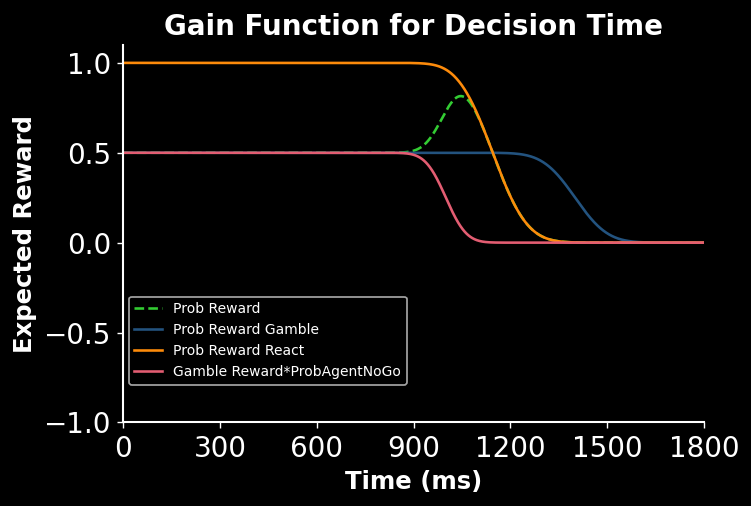

Optimal Decision Time: 1046
Maximum Expected Reward: 0.8151784226753318
Gamble Target Reach Time: 1145.8018764091703
Reaction Target Reach Time: 1400.875841834571


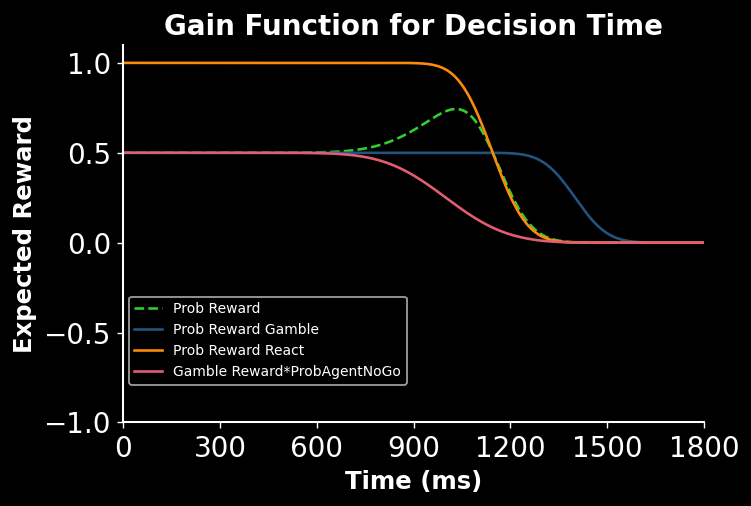

Optimal Decision Time: 1031
Maximum Expected Reward: 0.7434704338640724
Gamble Target Reach Time: 1130.8018764091703
Reaction Target Reach Time: 1385.875841834571


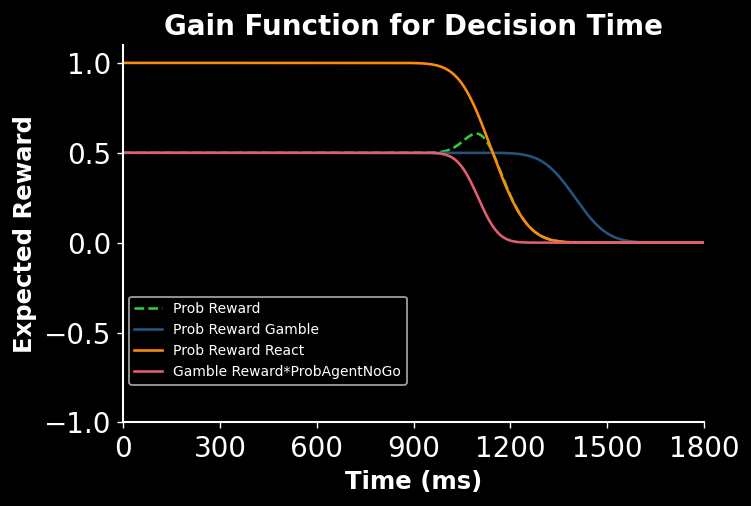

Optimal Decision Time: 1094
Maximum Expected Reward: 0.6065105347986367
Gamble Target Reach Time: 1193.8018764091703
Reaction Target Reach Time: 1448.875841834571


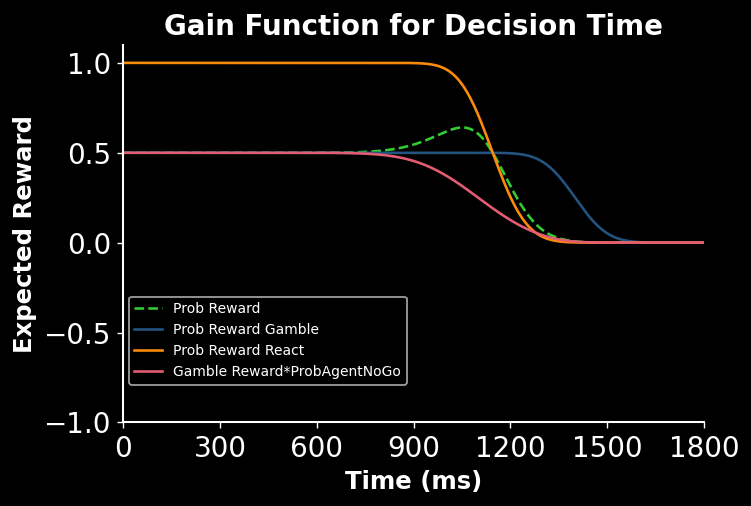

Optimal Decision Time: 1051
Maximum Expected Reward: 0.6405992884391947
Gamble Target Reach Time: 1150.8018764091703
Reaction Target Reach Time: 1405.875841834571


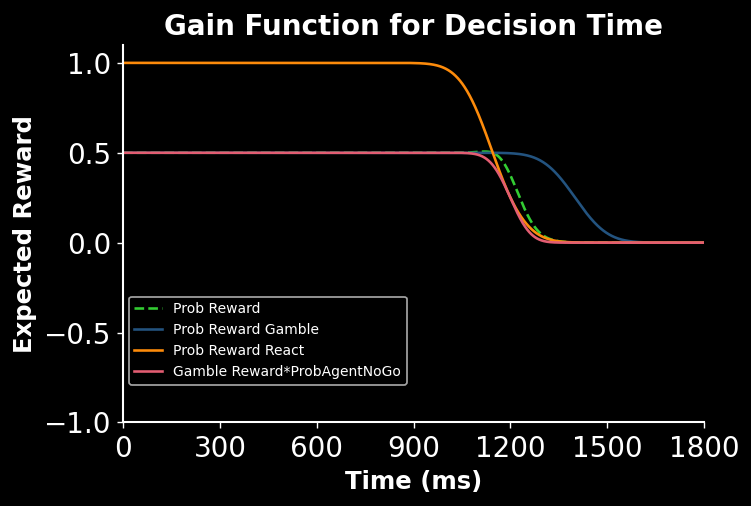

Optimal Decision Time: 1121
Maximum Expected Reward: 0.506732293030469
Gamble Target Reach Time: 1220.8018764091703
Reaction Target Reach Time: 1475.875841834571


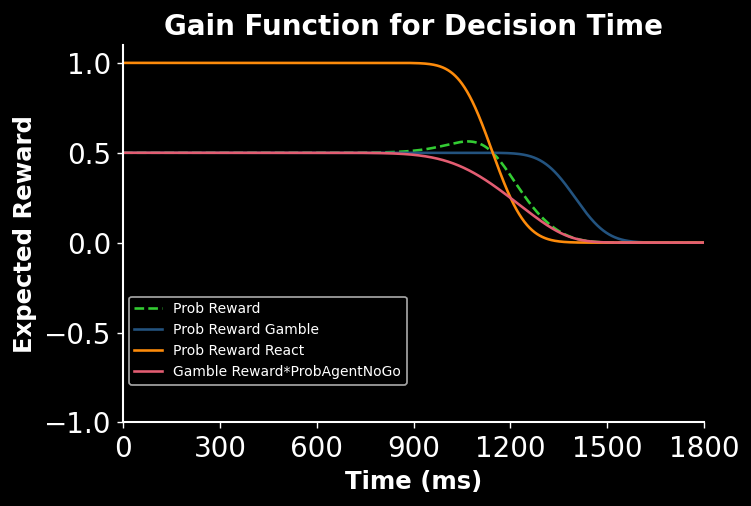

Optimal Decision Time: 1068
Maximum Expected Reward: 0.5630514892729082
Gamble Target Reach Time: 1167.8018764091703
Reaction Target Reach Time: 1422.875841834571
Reaction Time: 255.07396542540084
Movement Time: 99.80187640917029
Movement Uncertainty: 28.423902950702395
[1046. 1031. 1094. 1051. 1121. 1068.]


In [1240]:
agent_means = np.array([1000,1000,1100,1100,1200,1200])
agent_stds = np.array([50,150,50,150,50,150])
reaction_time = np.mean(player_reaction_time_mean) - 2*np.mean(player_reaction_time_sd)
movement_time = np.mean(player_task_mean_movement_time) - np.mean(player_reaction_movement_time_sd)
movement_uncertainty = np.mean(player_reaction_movement_time_sd) # NOT reaction+movement time, just the movement time in the reaction control condition
reaction_uncertainty = np.mean(player_reaction_time_sd)
timing_uncertainty = np.mean(coincidence_reach_time_sd)
# reaction_movement_uncertainty = 110
# movement_uncertainty = 50

optimal_decision_times = np.zeros(len(agent_means))
optimal_rewards = np.zeros(len(agent_means))
i=-1
for mean,std in zip(agent_means,agent_stds):
    i+=1
    optimal_decision_times[i],optimal_rewards[i] = find_optimal_decision_time(mean, std, reaction_time, movement_time, movement_uncertainty,reaction_uncertainty,timing_uncertainty,plot=True)

print(f'Reaction Time: {reaction_time}')
print(f'Movement Time: {movement_time}')
print(f'Movement Uncertainty: {movement_uncertainty}')
print(optimal_decision_times)

## Find Wins, Indecisions, Incorrects

In [1241]:
# Establish reach times
reach_time_gamble = optimal_decision_times + movement_time
reach_time_reaction = optimal_decision_times + reaction_time + movement_time

total_uncertainty = np.sqrt(np.mean(player_reaction_time_sd)**2 + np.mean(player_reaction_movement_time_sd)**2 + np.mean(coincidence_reach_time_sd)**2)
# Calculate difference of distributions
mean_diff = optimal_decision_times - agent_means
std_diff = np.sqrt(total_uncertainty**2 + agent_stds**2) 
prob_react = 1 - stats.norm.cdf(0, mean_diff,std_diff) # Probability that optimal decision time is after the agent goes (aka we react)  NEEDED TO DO THE TWO DISTRIBUTION DIFFERENCE THING
prob_gamble = 1 - prob_react

prob_indecision_if_react = 1 - stats.norm.cdf(1500,reach_time_reaction,total_uncertainty) # Probability that the reach time reaction is > 1500 
prob_indecision_if_gamble = 1 - stats.norm.cdf(1500,reach_time_gamble,total_uncertainty)
prob_indecision = prob_react*prob_indecision_if_react + prob_gamble*prob_indecision_if_gamble


prob_win_if_react = (1-prob_indecision_if_react)*1.0 # prob win if react is the probability that I don't make a decision times the probability that i select the right target (1.0)
prob_win_if_gamble = (1-prob_indecision_if_gamble)*0.5 # prob win if gamble is the probability that I don't make a decision times the probabiliyt that I select the right target(0.5)
prob_win = prob_react*prob_win_if_react + prob_gamble*prob_win_if_gamble


prob_incorrect_if_react = np.array([0]*len(agent_means))
prob_incorrect_if_gamble = (1-prob_indecision_if_gamble)*0.5
prob_incorrect = prob_react*prob_incorrect_if_react + prob_gamble*prob_incorrect_if_gamble

print(f'Agent means = {agent_means}')
print(f'Agent Stds = {agent_stds}')
print(f'Player uncertainty = {total_uncertainty}')
print(f'Prob indecision = {prob_indecision*100}')
print(f'Prob win =        {prob_win*100}')
print(f'Prob incorrect =  {prob_incorrect*100}')
print(prob_indecision + prob_win + prob_incorrect)

Agent means = [1000 1000 1100 1100 1200 1200]
Agent Stds = [ 50 150  50 150  50 150]
Player uncertainty = 83.87159097441794
Prob indecision = [ 8.08172246  4.96172922 12.89670464  5.07615765  8.12821599  3.96058819]
Prob win =        [75.97917926 73.61710198 60.88179576 64.31307698 52.35107324 57.10177685]
Prob incorrect =  [15.93909828 21.4211688  26.2214996  30.61076537 39.52071077 38.93763496]
[1. 1. 1. 1. 1. 1.]


## Plot Data and Optimals

Decision Times

In [1242]:
# Calculate what the LEAVE TARGET TIME IS FOR THE OPTIMAL SIMULATION
# Because people's decision time on gambles is equal to the target leave time
# And people's decision time on reactions is equal to target leave time - reaction time
# SO in the optimal, I need to calculate the target leave time based on the probabiilty of gamble and react and what time they would leave if they did react or gamble
optimal_gamble_decision_times = optimal_decision_times
optimal_reaction_decision_times = optimal_decision_times + reaction_time
wtd_optimal_mean_left_target_time = (prob_gamble*optimal_gamble_decision_times + prob_react*optimal_reaction_decision_times)

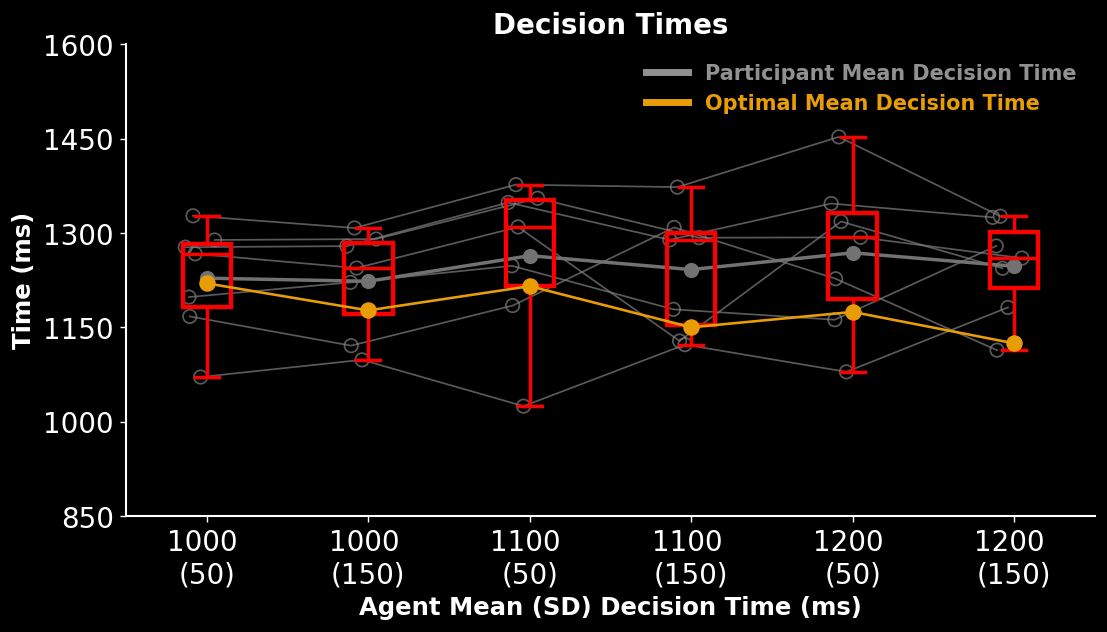

'C:\\Users\\Seth Sullivan\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\Modeling Figures\\Optimal Stopping Expected Reward Figures Group\\'

In [1243]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(400,1800,150)
plt.figure(dpi = 125, figsize = (10,5))
ax=plt.subplot()
reaction_time_matrix = np.vstack([player_reaction_time_mean] * player_mean_decision_time.shape[1]).T
boxplot(player_mean_decision_time, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Time (ms)', title='Decision Times')
dv.jitter_array(ax,xlocs,player_mean_decision_time.T,0.1, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.7, include_mean = True)
ax.plot(xlocs, wtd_optimal_mean_left_target_time, marker = 'o',markersize = 8.5, c= wheel.orange)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(850,1600)
dv.Custom_Legend(ax, ['Participant Mean Decision Time','Optimal Mean Decision Time'], [wheel.grey,wheel.orange], fontsize = 12)
plt.savefig(SAVE_PATH+'decision_times_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()
SAVE_PATH

Player Minus Agent Decision Times

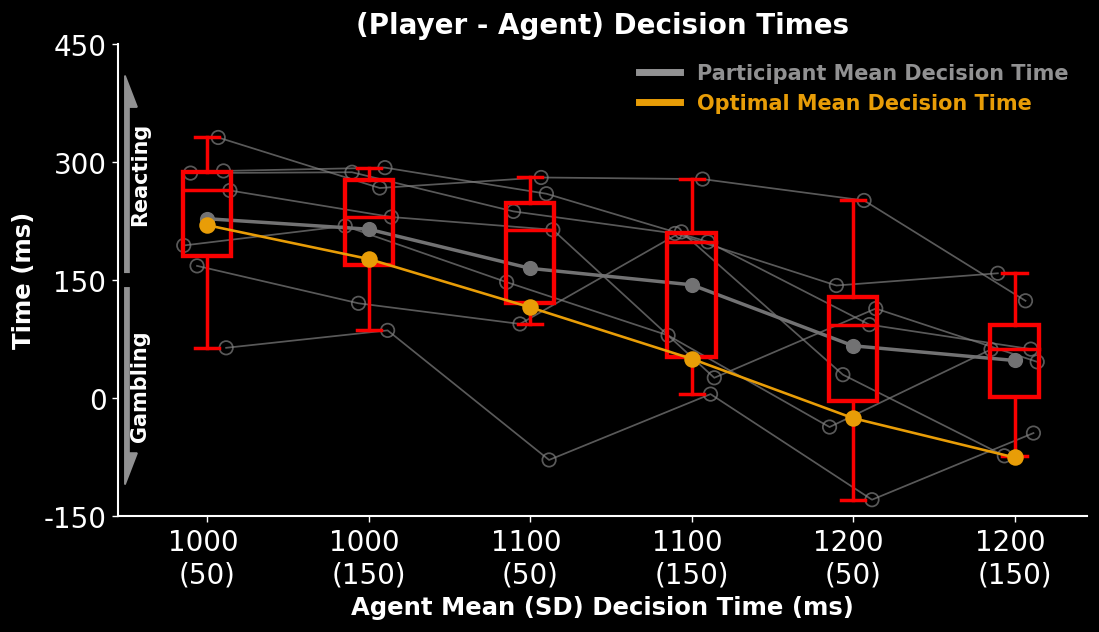

In [1263]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(-150,500,150)
plt.figure(dpi = 125, figsize = (10,5))
ax=plt.subplot()
player_minus_agent_decision_time_data = player_mean_decision_time - agent_mean_decision_time
player_minus_agent_decision_time_optimal = wtd_optimal_mean_left_target_time - agent_means 
boxplot(player_minus_agent_decision_time_data, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Time (ms)', title='(Player - Agent) Decision Times')
dv.jitter_array(ax,xlocs,player_minus_agent_decision_time_data.T,0.1, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.7, include_mean = True)
ax.plot(xlocs, player_minus_agent_decision_time_optimal, marker = 'o',markersize = 8.5, c= wheel.orange)
ax.arrow(-0.51,160,0,400-150, width = 0.05, length_includes_head = True,head_length = 40,head_width=0.15,shape = 'left',color=wheel.grey)
ax.text(-0.48,225,'Reacting',rotation = 90, fontweight='bold')
ax.arrow(-0.51,140,0,-250, width = 0.05, length_includes_head = True,head_length = 40,head_width=0.15,shape = 'right',color=wheel.grey)
ax.text(-0.48,-50,'Gambling',rotation = 90, fontweight='bold')
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(-150,450)
ax.set_xlim(-0.55,5.45)
dv.Custom_Legend(ax, ['Participant Mean Decision Time','Optimal Mean Decision Time'], [wheel.grey,wheel.orange], fontsize = 12)
plt.savefig(SAVE_PATH+'player_minus_agent_decision_times_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Indecisions

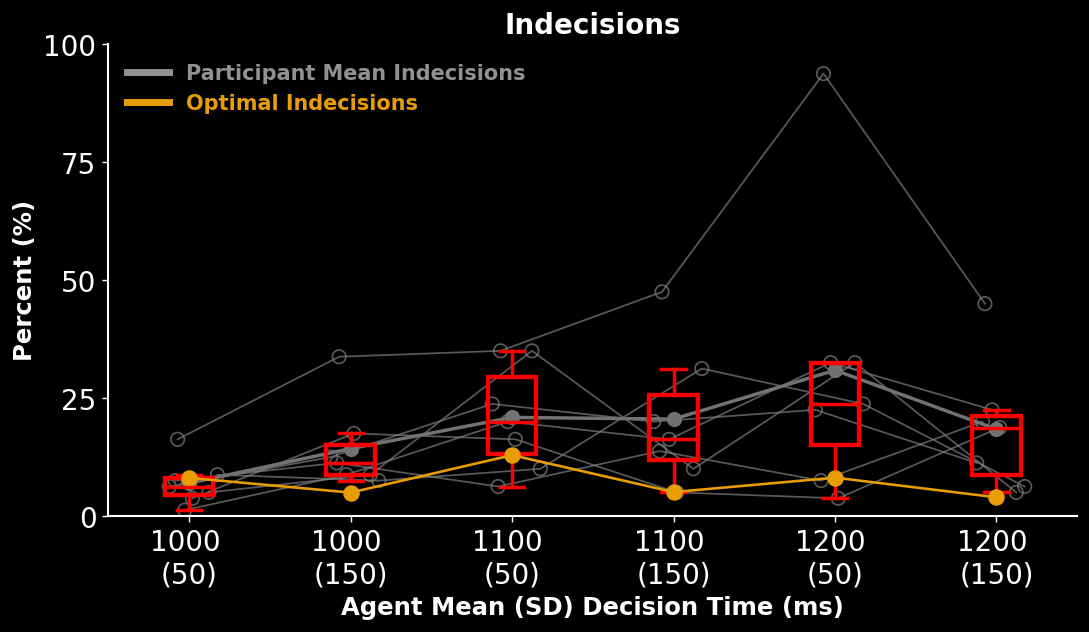

In [1245]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi = 125, figsize = (10,5))
ax=plt.subplot()
boxplot(perc_player_indecisions, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Percent (%)', title='Indecisions')
dv.jitter_array(ax,xlocs,perc_player_indecisions.T,0.1, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.7, include_mean = True)
ax.plot(xlocs, prob_indecision*100, marker = 'o',markersize = 8.5, c= wheel.orange)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
dv.Custom_Legend(ax, ['Participant Mean Indecisions','Optimal Indecisions'], [wheel.grey,wheel.orange], fontsize = 12)
plt.savefig(SAVE_PATH+'indecisions_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Wins

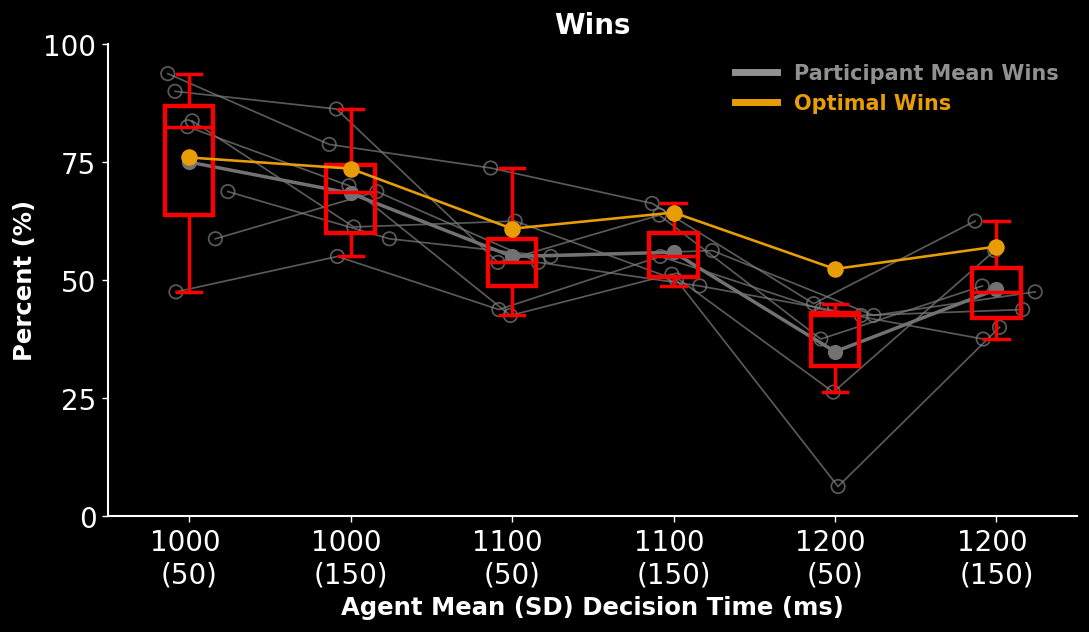

In [1246]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi = 125, figsize = (10,5))
ax=plt.subplot()
boxplot(perc_player_wins, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Percent (%)', title='Wins')
dv.jitter_array(ax,xlocs,perc_player_wins.T,0.1, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.7, include_mean = True )
ax.plot(xlocs, prob_win*100, marker = 'o',markersize = 8.5, c= wheel.orange)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
dv.Custom_Legend(ax, ['Participant Mean Wins','Optimal Wins'], [wheel.grey,wheel.orange], fontsize = 12)
plt.savefig(SAVE_PATH+'wins_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Incorrects

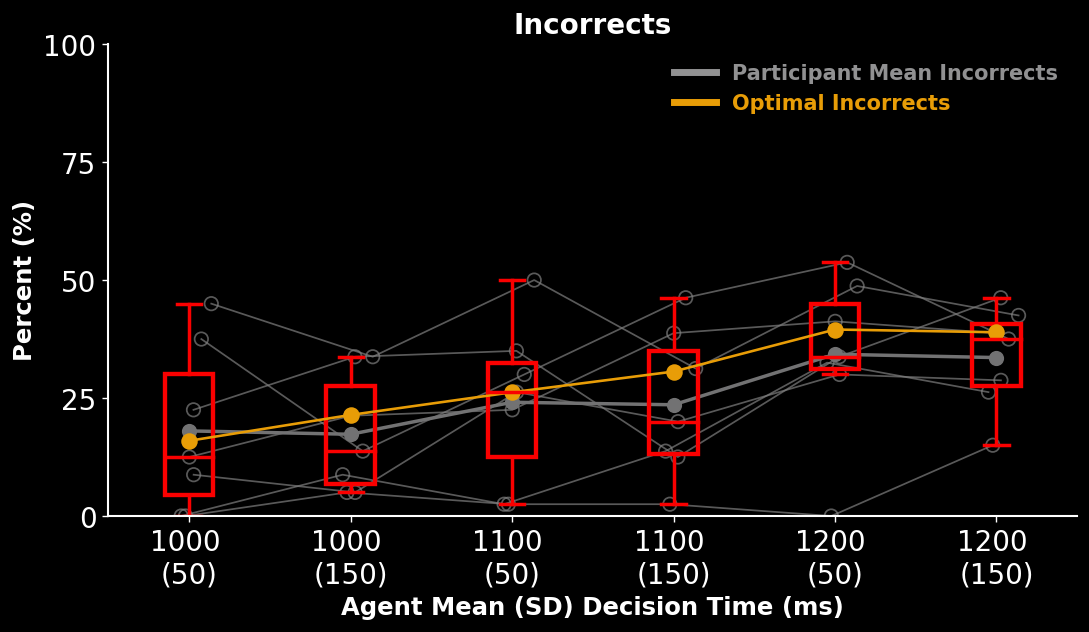

In [1247]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi = 125, figsize = (10,5))
ax=plt.subplot()
boxplot(perc_player_incorrects, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Percent (%)', title='Incorrects')
dv.jitter_array(ax,xlocs,perc_player_incorrects.T,0.1, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.7, include_mean = True )
ax.plot(xlocs, prob_incorrect*100, marker = 'o',markersize = 8.5, c= wheel.orange)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
dv.Custom_Legend(ax, ['Participant Mean Incorrects','Optimal Incorrects'], [wheel.grey,wheel.orange], fontsize = 12)
plt.savefig(SAVE_PATH+'incorrects_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Percent Reaction and Gamble Decisions

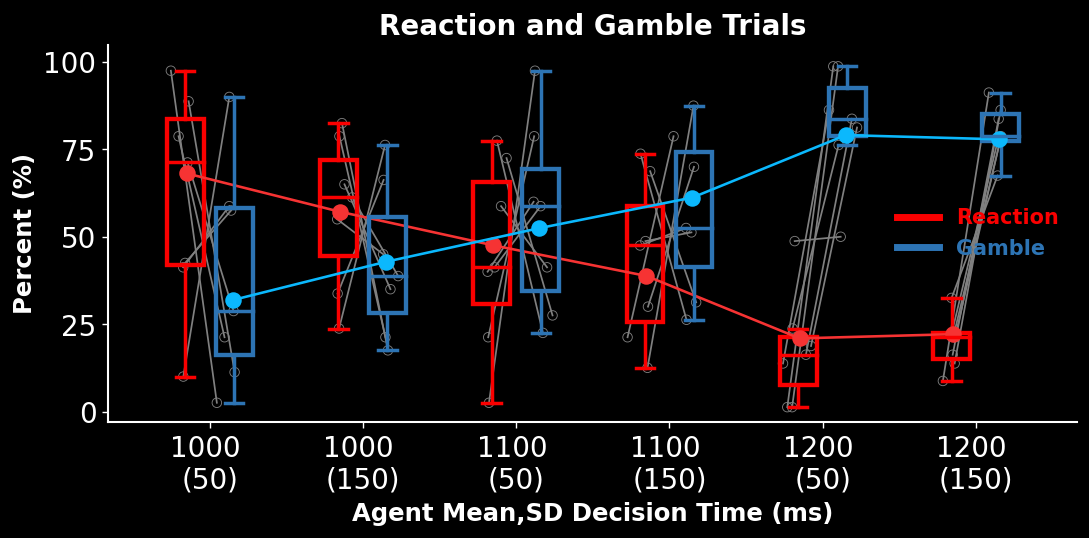

In [1256]:
#%% Plotting the number of reaction trials and number of gamble trials (percent) for each condition
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
box_width = 0.04
plt.figure(dpi=125, figsize=(10,4))
ax=plt.subplot()
boxplot(perc_reactions, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
# dv.jitter_array(ax=ax,x_positions=xlocs-0.15,data_list=perc_reactions.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-0.15, prob_react*100, marker = 'o',markersize = 8.5, c= wheel.red)

boxplot(perc_gambles, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"],xlab = "Agent Mean,SD Decision Time (ms)",
        ylab='Percent (%)', title='Reaction and Gamble Trials')
# dv.jitter_array(ax=ax,x_positions=xlocs+0.15,data_list=perc_gambles.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+0.15, prob_gamble*100, marker = 'o',markersize = 8.5, c= wheel.light_blue)

for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-0.15,0.15])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[perc_reactions[:,j],perc_gambles[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)

ax.set_ylim(-3,105)
ax.set_yticks(np.arange(0,101,25))
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(SAVE_PATH+'reaction_and_gamble_trial_percentages_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Reaction and Gamble Decision Times

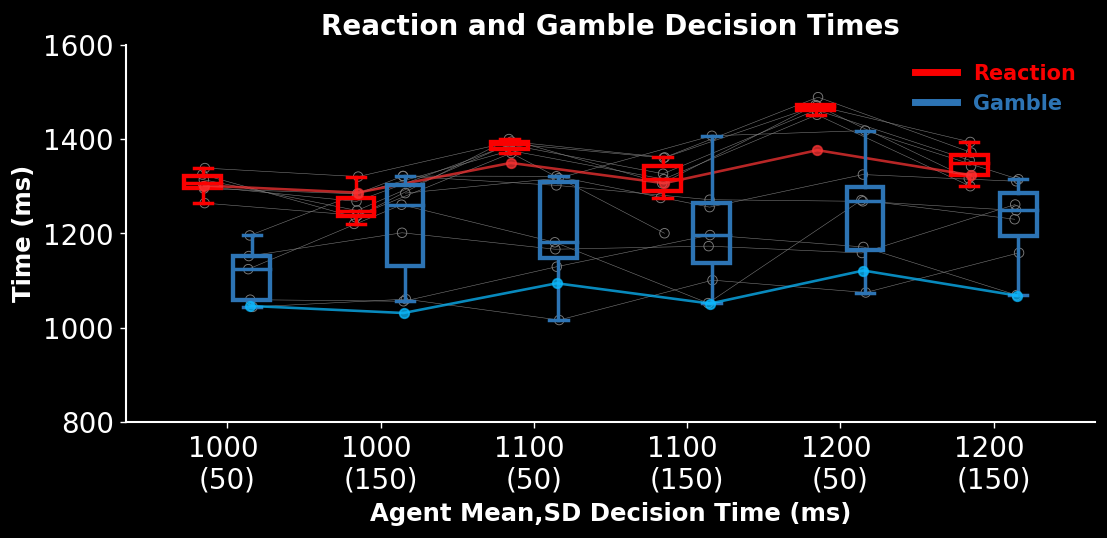

In [1257]:
#%% Decision time means for reactions and gambles for each condition
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(400,2000,200)
box_width = 0.04
plt.figure(dpi=125, figsize=(10,4))
ax=plt.subplot()
boxplot(reaction_decision_time_means, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
dv.jitter_array(ax=ax,x_positions=xlocs-0.15,data_list=reaction_decision_time_means.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-0.15, optimal_reaction_decision_times, marker = 'o',markersize = 5.5, c= wheel.red, alpha = 0.75)

boxplot(gamble_decision_time_means, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean,SD Decision Time (ms)",
        ylab='Time (ms)', title='Reaction and Gamble Decision Times')
dv.jitter_array(ax=ax,x_positions=xlocs+0.15,data_list=gamble_decision_time_means.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+0.15, optimal_gamble_decision_times, marker = 'o',markersize = 5.5, c= wheel.light_blue, alpha = 0.75)


ax.set_ylim(800,1600)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(SAVE_PATH+'reaction_and_gamble_decision_times_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

PLayer Minus Agent Gamble and Reaction Decision Times

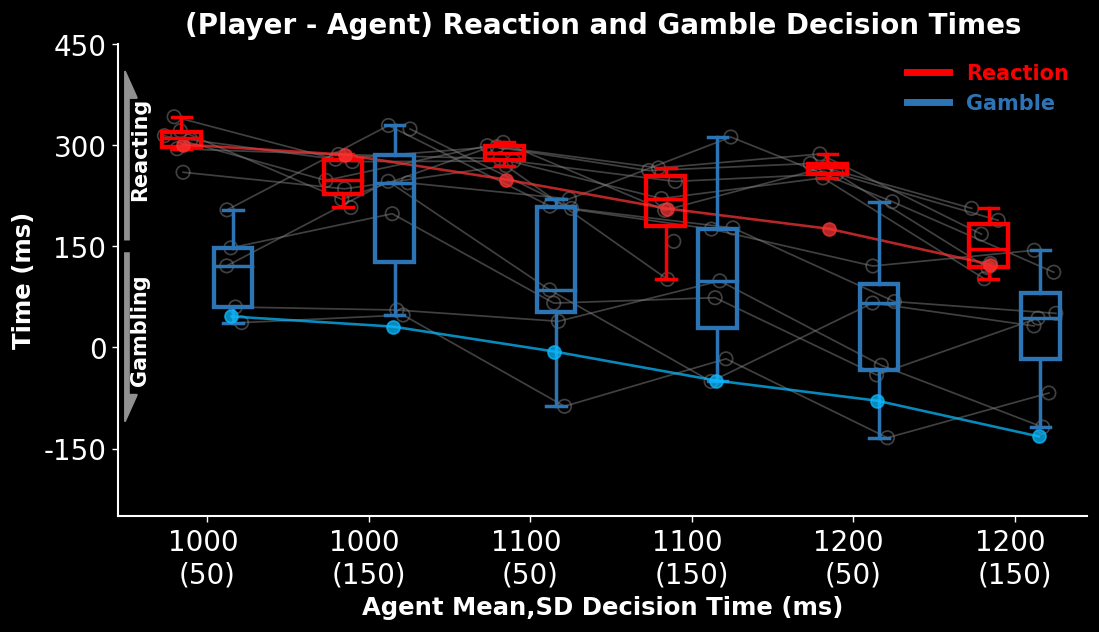

In [1258]:
#%% Decision time means for reactions and gambles for each condition
# Reaction_means - agent_means can be below someones reaction time because they might have only reacted to the agent when it went earlier... so the AGENT MEAN ON REACTIONS 
# is less than the condition mean

player_minus_agent_gamble_decision_times_data = gamble_decision_time_means - agent_mean_decision_time
player_minus_agent_reaction_decision_times_data = reaction_decision_time_means - agent_mean_decision_time
optimal_player_minus_agent_gamble_decision_times = optimal_gamble_decision_times - agent_means
optimal_player_minus_agent_reaction_decision_times = optimal_reaction_decision_times - agent_means

xlocs = np.arange(0, num_blocks)
ylocs = np.arange(-150,500,150)
plt.figure(dpi = 125, figsize = (10,5))
ax=plt.subplot()
player_minus_agent_decision_time_data = player_mean_decision_time - agent_mean_decision_time
player_minus_agent_decision_time_optimal = wtd_optimal_mean_left_target_time - agent_means 
boxplot(player_minus_agent_reaction_decision_times_data, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
dv.jitter_array(ax,xlocs-0.15,player_minus_agent_reaction_decision_times_data.T,0.07, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.5, include_mean = False)
ax.plot(xlocs-0.15, optimal_player_minus_agent_reaction_decision_times, marker = 'o',markersize = 7.5, c= wheel.red, alpha = 0.75)

boxplot(player_minus_agent_gamble_decision_times_data, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean,SD Decision Time (ms)",
        ylab='Time (ms)', title='(Player - Agent) Reaction and Gamble Decision Times')
dv.jitter_array(ax,xlocs+0.15,player_minus_agent_gamble_decision_times_data.T,0.07, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.5, include_mean = False)
ax.plot(xlocs+0.15, optimal_player_minus_agent_gamble_decision_times, marker = 'o',markersize = 7.5, c= wheel.light_blue, alpha = 0.75)

ax.arrow(-0.51,160,0,400-150, width = 0.05, length_includes_head = True,head_length = 40,head_width=0.15,shape = 'left',color=wheel.grey)
ax.text(-0.48,225,'Reacting',rotation = 90, fontweight='bold')
ax.arrow(-0.51,140,0,-250, width = 0.05, length_includes_head = True,head_length = 40,head_width=0.15,shape = 'right',color=wheel.grey)
ax.text(-0.48,-50,'Gambling',rotation = 90, fontweight='bold')
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(-250,450)
ax.set_xlim(-0.55,5.45)
# dv.Custom_Legend(ax, ['Participant Mean Decision Time','Optimal Mean Decision Time'], [wheel.grey,wheel.orange], fontsize = 12)
plt.savefig(SAVE_PATH+'reaction_and_gamble_player_minuus_agent_decision_times_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Agent Decision Times on Player Reactions and Gambles

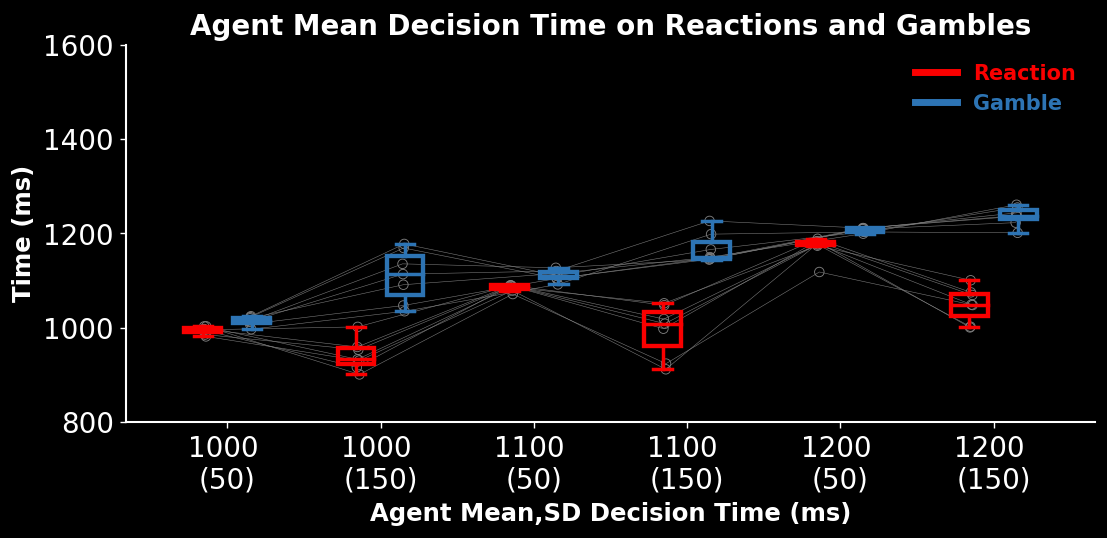

In [1259]:
#%% Decision time means for reactions and gambles for each condition
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(400,2000,200)
box_width = 0.04
plt.figure(dpi=125, figsize=(10,4))
ax=plt.subplot()
boxplot(agent_task_decision_time_reaction_means, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
dv.jitter_array(ax=ax,x_positions=xlocs-0.15,data_list=agent_task_decision_time_reaction_means.T, noise_scale=0.01, include_mean = False, circle_size=30)
# ax.plot(xlocs-0.15, optimal_reaction_decision_times, marker = 'o',markersize = 5.5, c= wheel.red, alpha = 0.75)

boxplot(agent_task_decision_time_gamble_means, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean,SD Decision Time (ms)",
        ylab='Time (ms)', title='Agent Mean Decision Time on Reactions and Gambles')
dv.jitter_array(ax=ax,x_positions=xlocs+0.15,data_list=agent_task_decision_time_gamble_means.T, noise_scale=0.01, include_mean = False, circle_size=30)
# ax.plot(xlocs+0.15, optimal_gamble_decision_times, marker = 'o',markersize = 5.5, c= wheel.light_blue, alpha = 0.75)


ax.set_ylim(800,1600)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(SAVE_PATH+'reaction_and_gamble_agent_mean_decision_times', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Gambles and Reaction Wins

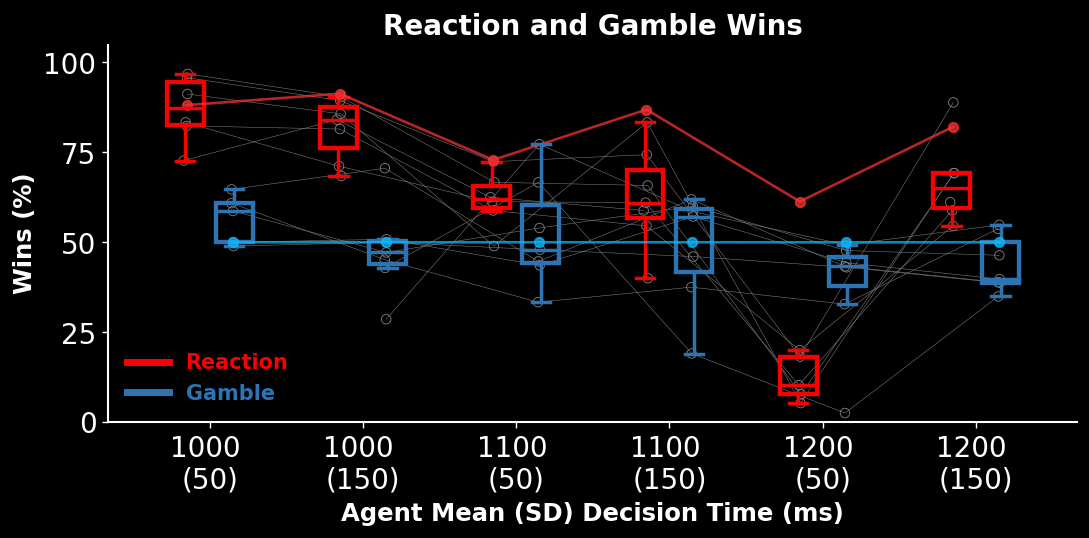

In [1260]:
# Out of x number of reaction trials, this percentage was how many they won (same for gambles)
# So it's  percent = reaction_wins/total_reaction_trials
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
box_width = 0.04
plt.figure(dpi=125, figsize=(10,4))
ax=plt.subplot()
boxplot(perc_reaction_wins, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
dv.jitter_array(ax=ax,x_positions=xlocs-0.15,data_list=perc_reaction_wins.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-0.15, prob_win_if_react*100, marker = 'o',markersize = 5.5, c= wheel.red, alpha = 0.75)

boxplot(perc_gamble_wins, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"],xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Wins (%)', title='Reaction and Gamble Wins')
ax.plot(xlocs+0.15, prob_win_if_gamble*100, marker = 'o',markersize = 5.5, c= wheel.light_blue, alpha = 0.75)

dv.jitter_array(ax=ax,x_positions=xlocs+0.15,data_list=perc_gamble_wins.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.set_ylim(0,105)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(SAVE_PATH+'reaction_and_gamble_wins_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Reaction and Gamble Indecisions

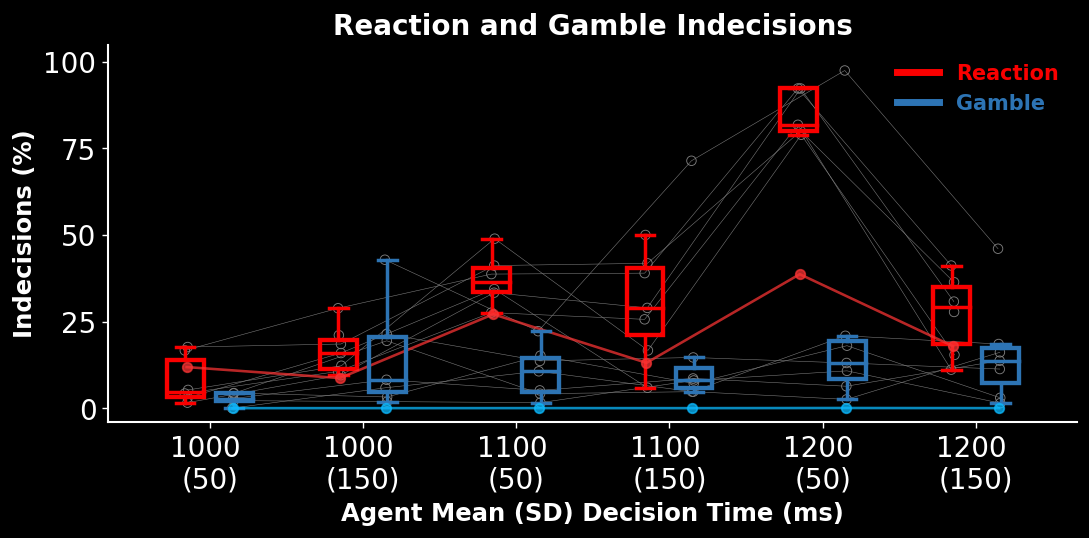

In [1261]:
# Percent = reaction indecisions / total Reaction trials
# !!!!!!!! WHEN THEY REACTED, HOW OFTEN DID THEY MAKE AN INDECISION
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
box_width = 0.04
plt.figure(dpi=125, figsize=(10,4))
ax=plt.subplot()
boxplot(perc_reaction_indecisions, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
dv.jitter_array(ax=ax,x_positions=xlocs-0.15,data_list=perc_reaction_indecisions.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-0.15, prob_indecision_if_react*100, marker = 'o',markersize = 5.5, c= wheel.red, alpha = 0.75)

boxplot(perc_gamble_indecisions, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"],xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Indecisions (%)', title='Reaction and Gamble Indecisions')
dv.jitter_array(ax=ax,x_positions=xlocs+0.15,data_list=perc_gamble_indecisions.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+0.15, prob_indecision_if_gamble*100, marker = 'o',markersize = 5.5, c= wheel.light_blue, alpha = 0.75)

ax.set_ylim(-4,105)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(SAVE_PATH+'reaction_and_gamble_indecisions_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Reaction Gamble Incorrects

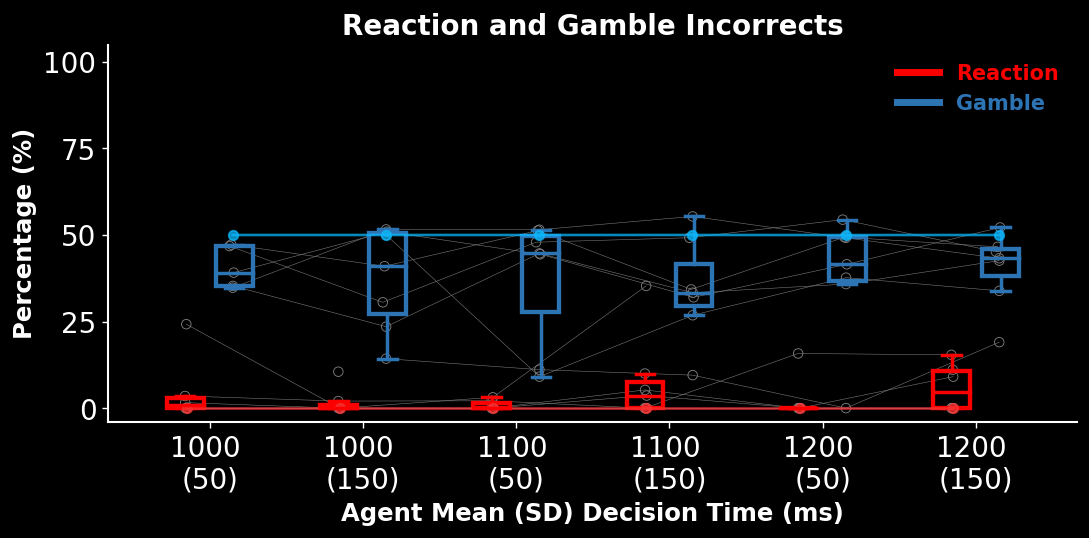

In [1262]:
# Percent = reaction incorrects / total Reaction trials
# !!!!!!!! WHEN THEY REACTED, HOW OFTEN DID THEY MAKE AN incorrects
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
box_width = 0.04
plt.figure(dpi=125, figsize=(10,4))
ax=plt.subplot()
boxplot(perc_reaction_incorrects, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
dv.jitter_array(ax=ax,x_positions=xlocs-0.15,data_list=perc_reaction_incorrects.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-0.15, prob_incorrect_if_react*100, marker = 'o',markersize = 5.5, c= wheel.red, alpha = 0.75)

boxplot(perc_gamble_incorrects, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"],xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Percentage (%)', title='Reaction and Gamble Incorrects')
dv.jitter_array(ax=ax,x_positions=xlocs+0.15,data_list=perc_gamble_incorrects.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+0.15, prob_incorrect_if_gamble*100, marker = 'o',markersize = 5.5, c= wheel.light_blue, alpha = 0.75)

ax.set_ylim(-4,105)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(SAVE_PATH+'reaction_and_gamble_incorrects_boxplots_with_optimal', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()